In this project, I built a convolutional neural network (CNN) that can classify images of hand gestures (rock, paper, scissors) using the Tensorflow library. The dataset contains 2,188 images of hands in Rock, Paper, and Scissors poses. The images are 300x200 pixels in size and are in color.

In [8]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

Paths to the rock, paper, and scissors images folders:

In [9]:
rock_dir = './rock'
paper_dir = './paper'
scissors_dir = './scissors'

In [10]:
def color_distance(color_1_array_256, color_2_array_256):
	return np.sqrt(np.sum((color_1_array_256 - color_2_array_256) ** 2))

Simplify a color, if its similar to the board color (green) then replace with black, if its similar to the skin color then replace with white.

In [11]:
color_replacement_dict = {
    (46, 161, 63): [0, 0, 0], # board -> black
    (188, 150, 117): [255, 255, 255], # skin -> white
}

def simplify_color(color_array_256):
    closest_simple_color = None # array of 3 elements, ignore color labels
    # closest distance is infinity
    closest_distance = float("inf")
    for keycolor, target_color in color_replacement_dict.items():
        distance = color_distance(color_array_256, keycolor)
        if distance < closest_distance:
            closest_distance = distance
            closest_simple_color = target_color
    return closest_simple_color

Simplify the color pallete of an image

In [12]:
def decrease_color_complexity(img, f):
    for i in range(len(img)):
        for j in range(len(img[i])):
            img[i][j] = f(img[i][j])

In [13]:
def apply_processing_to_img(img):
	img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
	img = cv2.resize(img, (30, 30))
	decrease_color_complexity(img, simplify_color)
	return img

Preparing the data by using load_images_labels() function. This function takes the path to the images folder and returns a list of images and a list of labels. In this case, I'm also applying the proccesing function to the images.

In [14]:
def load_images_labels(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        # print(filename)
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            img = apply_processing_to_img(img)
            images.append(img)
            labels.append(label)
    return images, labels

rock_images, rock_labels = load_images_labels(rock_dir, 0)
paper_images, paper_labels = load_images_labels(paper_dir, 1)
scissors_images, scissors_labels = load_images_labels(scissors_dir, 2)

X = np.array(rock_images + paper_images + scissors_images)
y = np.array(rock_labels + paper_labels + scissors_labels)

Division into training and test sets is 80% and 20%. The training set is used to train the model, while the test set is used to evaluate the model's performance.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

Normalization of the images is done by dividing each pixel value by 255.0. This ensures that the pixel values are in the range [0,1]. It's done to make the model easier to train.

In [16]:
X_train = X_train / 255.0
X_test = X_test / 255.0

Explanation of layers used to build the model:

Conv2D is a convolutional layer.
- It applies a set of filters to the input image, where each filter learns to detect a specific feature in the image. 
- In this example, we have a convolutional layer with 32 filters of size 3x3.
- The activation function used is Rectified Linear Unit (ReLU). 
- ReLU is an activation function that sets all negative values to zero and leaves positive values unchanged.

MaxPooling2D is a pooling layer.
- It reduces the dimensionality of each feature map but retains the most important information.
- In this example, we have a pooling layer with a pool size of 2x2.

Flatten is a flattening layer.
- It converts the final feature maps into a one single 1D vector. 
- This is done so that the output can be processed by a fully connected layer.

Dense is a fully connected layer.
- It connects all neurons in the previous layer to the next layer.
- In this example, we have a fully connected layer with 512 neurons.
- The activation function used is Rectified Linear Unit (ReLU).

Dropout is a regularization technique.
- It randomly drops neurons during training.
- This helps to prevent overfitting.

Softmax is an activation function (used in the output layer).
- It converts the output to a probability distribution.

The model is compiled using the Adam optimizer and the categorical crossentropy loss function. The Adam optimizer is an extension to stochastic gradient descent. The categorical crossentropy loss function is used for multi-class classification problems.

In [17]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(30, 30, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Training the model using the fit() function. The model is trained for 10 epochs (iterations over the entire training set).

In [18]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
55/55 [==============================] - 2s 20ms/step - loss: 0.3673 - accuracy: 0.8600 - val_loss: 0.1154 - val_accuracy: 0.9589
Epoch 2/10
55/55 [==============================] - 1s 17ms/step - loss: 0.1205 - accuracy: 0.9600 - val_loss: 0.0566 - val_accuracy: 0.9795
Epoch 3/10
55/55 [==============================] - 1s 16ms/step - loss: 0.0619 - accuracy: 0.9811 - val_loss: 0.0618 - val_accuracy: 0.9772
Epoch 4/10
55/55 [==============================] - 1s 15ms/step - loss: 0.0776 - accuracy: 0.9726 - val_loss: 0.0439 - val_accuracy: 0.9863
Epoch 5/10
55/55 [==============================] - 1s 19ms/step - loss: 0.0316 - accuracy: 0.9931 - val_loss: 0.0285 - val_accuracy: 0.9932
Epoch 6/10
55/55 [==============================] - 1s 16ms/step - loss: 0.0309 - accuracy: 0.9914 - val_loss: 0.0233 - val_accuracy: 0.9977
Epoch 7/10
55/55 [==============================] - 1s 17ms/step - loss: 0.0178 - accuracy: 0.9960 - val_loss: 0.0202 - val_accuracy: 0.9909
Epoch 8/10
55

Plots of the training and validation accuracy and loss.

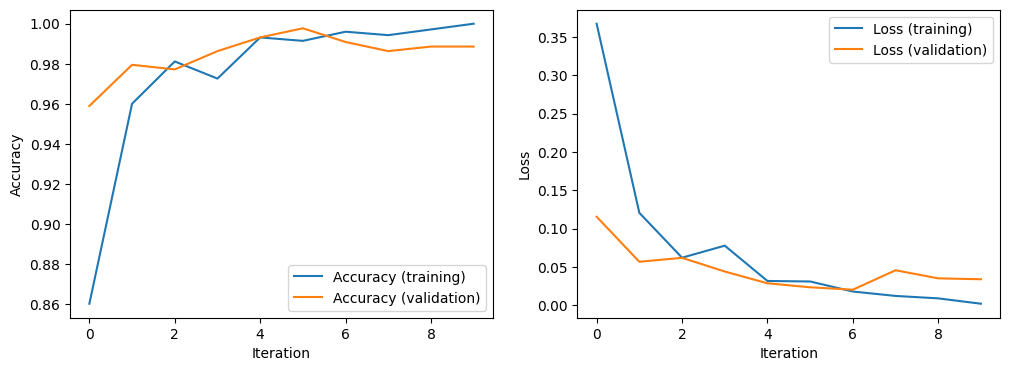

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy (training)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation)')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Accuracy')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss (training)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Confusion matrix:

14/14 [==============================] - 0s 5ms/step


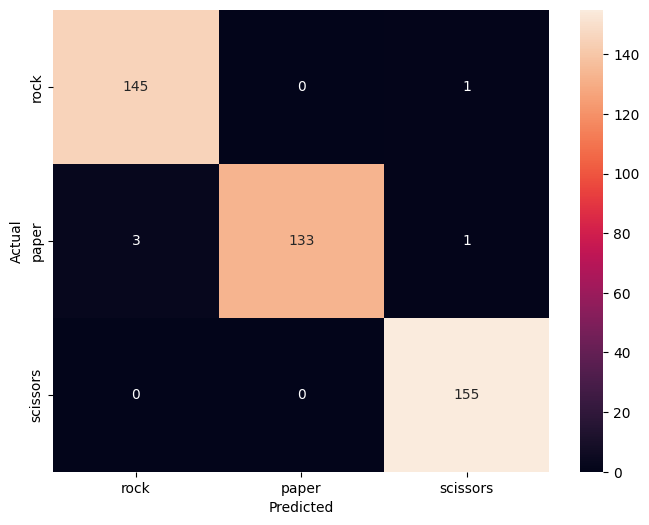

Accuracy:  98.85844748858447 %


In [20]:
labels = ['rock', 'paper', 'scissors']

y_pred = model.predict(X_test)


y_pred = np.argmax(y_pred, axis=1)


cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
print('Accuracy: ', np.sum(y_pred == y_test) / len(y_test) * 100, '%')

In [21]:
# display misclassified images
# arr = np.where(y_pred != y_test)
# for i in arr[0][:9]:
#     plt.figure(figsize=(4, 4))
#     plt.imshow(X_test[i])
#     plt.title(f"Actual: {labels[y_test[i]]}, Predicted: {labels[y_pred[i]]}")
#     plt.axis('off')
#     plt.show()
#     # save image
#     plt.savefig(f"./mis/{i}.png")

Bibliography:

- https://www.tensorflow.org/api_docs/python/tf/keras/

- https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors

- https://en.wikipedia.org/wiki/Convolutional_neural_network